# Introduction

This notebook contains a submission for the Vehicle Detection and Tracking project of the Self-Driving Car Nanodegree.

The submission consists of three major parts:
1. Implementation and traning of the vehicle detection classifier
1. Implementation of the sliding window search
1. Implementation and demonstration of the vehicle tracking pipeline


Here are some general Python imports required by the following code:

In [1]:
import os
import glob
import time

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2

%matplotlib inline

Here is a utility function which handles the different scaling needed for JPEG and PNG images. I'll use it to load the images in the following code.

In [2]:
def read_image(path):
    image = mpimg.imread(path)
    return (image * 255).astype('uint8') if path.endswith('.png') else image

# The Vehicle Detection Classifier

Here I first include some of the feature extraction code from the lesson. A change I made is to use the read_image function defined above.

In [3]:
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                     hist_bins=32, orient=9, 
                     pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = read_image(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                                                pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

## Loading the training images
Now I read in the training images for cars and non-cars. I added a simple utility function for finding all PNG images under a given root folder:

In [4]:
def find_png_images(root_folder):
    image_paths = []
    for root, dirs, filenames in os.walk(root_folder):
        for filename in filenames:
            if filename.endswith('.png'):
                image_paths.append(os.path.join(root, filename))
    return image_paths
    
# Read in cars and notcars
cars = find_png_images('vehicles')
notcars = find_png_images('non-vehicles')
print('Found {} vehicle images and {} non-vehicle images'.format(len(cars), len(notcars)))

Found 8792 vehicle images and 8968 non-vehicle images


## Feature extraction
Now I am ready to do the actual feature extraction for the training data. I started with the parameter values from the lessons for features extraction (both color and HOG features). Those values seemed to result decent classifier performance, but I also tested YUV color space and using all color channels for extracting the HOG features. These values proved to be even better so I kept those.

In [28]:
### TODO: Tweak these parameters and see how the results change.
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, None] # Min and max in y to search in slide_window()

print('Using:', orient, 'orientations', pix_per_cell,      'pixels per cell and', cell_per_block,'cells per block')

car_features = extract_features(cars, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                                   spatial_size=spatial_size, hist_bins=hist_bins, 
                                   orient=orient, pix_per_cell=pix_per_cell, 
                                   cell_per_block=cell_per_block, 
                                   hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                   hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

Using: 9 orientations 8 pixels per cell and 2 cells per block


## Training the classifier
With the features extracted, I can train the classifier. I use the support vector classifier from the lessons:

In [29]:
from sklearn.model_selection import train_test_split

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

Feature vector length: 6108
46.85 Seconds to train SVC...
Test Accuracy of SVC =  0.9913


# Sliding Window Search
For searching cars from images I use the sliding window search from the lesson. Here are the Python functions needed:

In [30]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                                       spatial_size=spatial_size, hist_bins=hist_bins, 
                                       orient=orient, pix_per_cell=pix_per_cell, 
                                       cell_per_block=cell_per_block, 
                                       hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                       hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                 xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

### Testing the classifier
Now I can actually do some testing of the vehicle detection with some images. I'll use the test images from the advanced lane finding project, plus the one test image from the lessons.

I selected three different window sizes: 72x72, 96x96 and 115x115. These sizes seem cover cars that are somewhat far away from the camera to the ones that are fairly close to the camera. Using multiple window sizes will likely result to increase in false positives, which need to be dealt with later.

test_images/bbox-example-image.jpg (720, 1280, 3) uint8 0 255
test_images/straight_lines1.jpg (720, 1280, 3) uint8 0 255
test_images/straight_lines2.jpg (720, 1280, 3) uint8 0 255
test_images/test1.jpg (720, 1280, 3) uint8 0 255
test_images/test2.jpg (720, 1280, 3) uint8 0 255
test_images/test3.jpg (720, 1280, 3) uint8 0 255
test_images/test4.jpg (720, 1280, 3) uint8 0 255
test_images/test5.jpg (720, 1280, 3) uint8 0 255
test_images/test6.jpg (720, 1280, 3) uint8 0 255


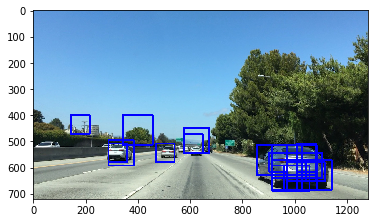

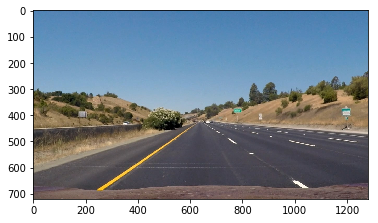

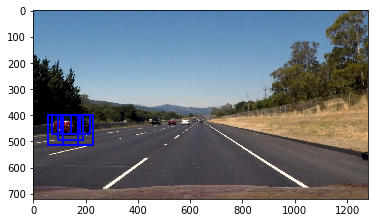

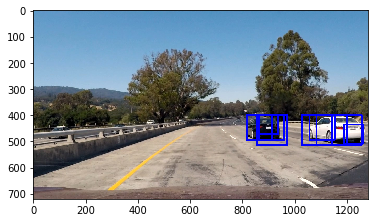

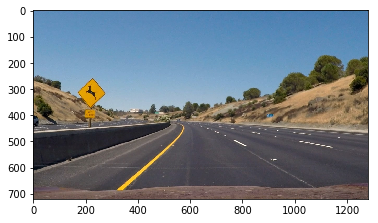

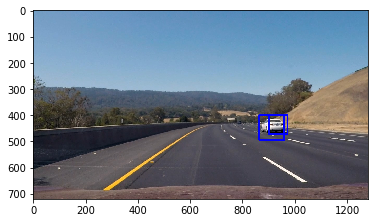

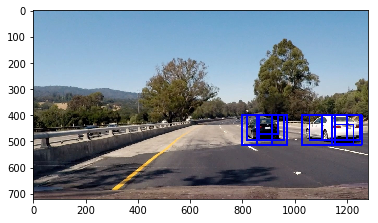

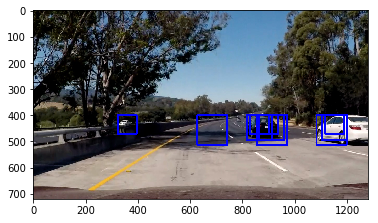

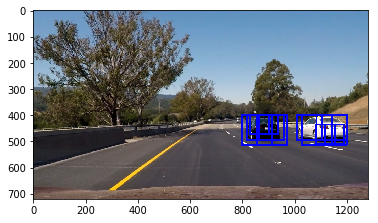

In [31]:

def search_cars(image):
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                           xy_window=(96, 96), xy_overlap=(0.5, 0.5))
    windows += slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                            xy_window=(72, 72), xy_overlap=(0.5, 0.5))
    windows += slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                            xy_window=(115, 115), xy_overlap=(0.5, 0.5))

    return search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                          spatial_size=spatial_size, hist_bins=hist_bins, 
                          orient=orient, pix_per_cell=pix_per_cell, 
                          cell_per_block=cell_per_block, 
                          hog_channel=hog_channel, spatial_feat=spatial_feat, 
                          hist_feat=hist_feat, hog_feat=hog_feat)                       

for image_path in glob.glob('test_images/*.jpg'):
    image = read_image(image_path)
    print(image_path, image.shape, image.dtype, image.min(), image.max())
    draw_image = np.copy(image)
    hot_windows = search_cars(image)
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
    plt.figure()
    plt.imshow(window_img)

There are some false positives in the detection results, especially in shadows. These need to be handled somehow later.

# Vehicle Tracking

Next I need to start working with the provided test video and see how things work there. First I need a function for processing a video file using an image processing pipeline given as an argument.

In [32]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def process_video(fname, output_fname, image_processor):
    clip = VideoFileClip(fname)
    output_clip = clip.fl_image(image_processor)
    %time output_clip.write_videofile(output_fname, audio=False)
    return output_fname

Now I can define a simple image processing pipeline using the sliding window search.

In [33]:
def simple_process_image(image):
    draw_image = np.copy(image)
    hot_windows = search_cars(image)
    return draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

Let's test it out with the test video:

In [34]:
clip_1 = process_video('test_video.mp4', 'test_video_simple.mp4', simple_process_image)

[MoviePy] >>>> Building video test_video_simple.mp4
[MoviePy] Writing video test_video_simple.mp4


 97%|█████████▋| 38/39 [02:24<00:03,  3.80s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_simple.mp4 

CPU times: user 2min 23s, sys: 631 ms, total: 2min 24s
Wall time: 2min 25s


In [35]:

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(clip_1))

This test shows the same problem wiht false positivies as the test images, but it also shows that the actual cars are detected fairly consistently.

## Using a heat map for filtering false positives
I will use the heat map implementation from the lessons to see how it handles the false positives. Here is the code:

In [36]:
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

And here is modified image processing function that uses the heat map to filter the detected bounding boxes. To provide some frame-to-frame filtering I added 10 frame heat map history and a sum heat map that records the total heat from those 10 frames. I use three as a threshold value for the sum to remove intermittent false positive detections.

In [47]:
heat_history = []
history_size = 10
heat_sum = np.zeros((720,1280)).astype(np.float64)

def reset_heat_history():
    global heat_sum 
    heat_history.clear()
    heat_sum = np.zeros((720,1280)).astype(np.float64)

def filtered_process_image(image):
    global heat_sum
    
    draw_image = np.copy(image)
    hot_windows = search_cars(image)
    
    current_heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    current_heat = add_heat(current_heat, hot_windows)
    # Apply threshold to help remove false positives
    current_heat = apply_threshold(current_heat, 1)
    
    # Integrate several heat maps together
    heat_sum += current_heat
    heat_history.append(current_heat)
    if len(heat_history) > history_size:
        # Remove the oldest heat map
        oldest_heat = heat_history.pop(0)
        heat_sum -= oldest_heat

    heat_sum = np.clip(heat_sum, 0, 255)
    heat = apply_threshold(heat_sum, 2)

    # Find final boxes from heatmap using label function
    labels = label(heat)
    return draw_labeled_bboxes(np.copy(image), labels)

Let's see how the heat map filtering behaves with the project video:

In [48]:
reset_heat_history()
clip_2 = process_video('test_video.mp4', 'test_video_filtered.mp4', filtered_process_image)
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(clip_2))

[MoviePy] >>>> Building video test_video_filtered.mp4
[MoviePy] Writing video test_video_filtered.mp4


 97%|█████████▋| 38/39 [02:25<00:03,  3.84s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_filtered.mp4 

CPU times: user 2min 25s, sys: 757 ms, total: 2min 25s
Wall time: 2min 27s


Most of the false positives are gone, although not nearly all of them. The vehicle detection is somewhat improved also, with the overlapping bounding boxes combined to some level, but the detection is still quite unreliable. 

In [49]:
reset_heat_history()
clip_3 = process_video('project_video.mp4', 'project_video_filtered.mp4', filtered_process_image)
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(clip_3))

[MoviePy] >>>> Building video project_video_filtered.mp4
[MoviePy] Writing video project_video_filtered.mp4


100%|█████████▉| 1260/1261 [1:20:13<00:03,  3.89s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_filtered.mp4 

CPU times: user 1h 19min 48s, sys: 23.4 s, total: 1h 20min 11s
Wall time: 1h 20min 14s


There are very few false positive detections, but on the other hand the car detections are not very clean, they tend to split to smaller blocks quite often. 

# Discussion
I basically used the code from the lessons with minor modifications. I did some testing with the detector features to find a bit better parameters. I spent initially quite a lot of time testing with the full project video, which meant long rendering times. Then I noticed that there was the shorted test video in the project repo and started using that instead.

Some improvement ideas to my system:
* Adding the more efficent HOG calculation idea given in the lessons. I did not try that because I found it a bit too confusing to add to the current code.
* Tracking of the cars could be improved with a better algorithm that keeps record of the car locations, which could also help in focusing the detection to previous car locations. 
* More testing with the window sizes could possibly help in detecting the cars that are farther away.

This pipeline seems to fairly resistant to false positivies when the lighting is good, but it is not possible to say how it will fare when the lightning changes without more testing. The pipeline cannot also handle the cars cleanly as single item but tends to split them up to smaller detections, which could possible be improved with more parameter tuning.